In [59]:
import pandas as pd
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.data.vision import transforms
import gluoncv
import cv2
from mxnet import ndarray as nd

# 数据预处理

In [3]:
df = pd.read_json("./bk-det-groundtruth-0420.json", lines=True)
df.head()

img_with_no_data = []
classes = []

import os, shutil
for i in range(len(df)):
    if df.iloc[i].label[0]["data"]:
        classes.append(df.iloc[i].label[0]["data"][0]["class"])
    else:
        img_with_no_data.append(df.iloc[i].url.split("/")[-1])
        src =  './images/' + df.iloc[i].url.split("/")[-1]
        dst = './problemImage/' + df.iloc[i].url.split("/")[-1]
        shutil.move(src, dst)

FileNotFoundError: [Errno 2] No such file or directory: './images/terror-detect-2018-04-01T05-56-01-i-ysb9msgg4ftkNG2wVpIQ=='

In [4]:
for i in range(len(df)):
    src = "./images/" + df.iloc[i].url.split("/")[-1]
    if df.iloc[i].label[0]["data"]:
        if df.iloc[i].label[0]["data"][0]["class"] == 'terror':
            dst = "./classified-images/terror/" + df.iloc[i].url.split("/")[-1] + ".jpg"
            shutil.copy(src, dst)
        elif df.iloc[i].label[0]["data"][0]["class"] == 'normal':
            dst = "./classified-images/normal/" + df.iloc[i].url.split("/")[-1] + ".jpg"
            shutil.copy(src, dst)
    else:
        print(src)

KeyboardInterrupt: 

# start to play !

In [60]:
from mxnet.gluon.data.vision import ImageFolderDataset
import cv2
import numpy as np
from mxnet import ndarray as nd
class pyyData(ImageFolderDataset):
    def __init__(self, *arg1, **arg2):
        super(pyyData,self).__init__(*arg1,**arg2)

    def __getitem__(self, idx):
        '''
        use cv2 backend
        '''
        img  = cv2.imread(self.items[idx][0])
        if img.shape[2] == 1:
            # read an gray map
            img = cv2.cvtcolor(img,cv2.color_gray2rgb)
        img  = nd.array( img[:,:,:3]).astype(np.uint8)
        label = self.items[idx][1]
        if self._transform is not None:
            return self._transform(img, label)
        return img, label


transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_path = "./classified-images"
batch_size = 256
num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]

test_data = gluon.data.DataLoader(
    pyyData(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=True, num_workers = num_workers,last_batch = 'discard')

# 预训练模型下载

In [50]:
from mxnet.gluon import nn
from mxnet import gluon, image, init, nd
model_name = 'ResNet50_v1d'
finetune_net = gluoncv.model_zoo.get_model(model_name, pretrained=True)

with finetune_net.name_scope():
    finetune_net.fc = nn.Dense(2)
finetune_net.fc.initialize(init.Xavier(), ctx = ctx)
finetune_net.collect_params().reset_ctx(ctx)
finetune_net.hybridize()

In [72]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.get_model(name='resnet50_v2', ctx=ctx, pretrained=True, classes=1000)
pretrained_net.cast('float16')

net = models.get_model(name='resnet50_v2', ctx=mx.gpu(0), pretrained=False, classes=2)
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
# net.features = pretrained_net.features
net.cast(dtype="float16")

In [32]:
import mxnet.ndarray as nd
nd.array([1,2,3],ctx = mx.gpu(0))


[1. 2. 3.]
<NDArray 3 @gpu(0)>

In [51]:
import time
t0 = time.time()
ctx  = [mx.gpu(0)]
for idx , g in enumerate(test_data):
    g[0] = g[0].as_in_context(mx.gpu(0))
    y = finetune_net(g[0])

print(time.time() - t0)
print((time.time() - t0) / len(test_data))

58.941447019577026
1.3098251183827718


In [84]:
from mxnet.gluon import nn
from mxnet import gluon, image, init, nd

model_name = 'ResNet50_v1d'
finetune_net = gluoncv.model_zoo.get_model(model_name, pretrained=True)
# with finetune_net.name_scope():
#     finetune_net.output = nn.Dense(classes)
# finetune_net.output.initialize(init.Xavier(), ctx = ctx)
# finetune_net.collect_params().reset_ctx(ctx)
# finetune_net.hybridize()

# trainer = gluon.Trainer(finetune_net.collect_params(), 'sgd', {
#                         'learning_rate': lr, 'momentum': momentum, 'wd': wd})
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

In [21]:
from mxnet.gluon.data.vision import ImageFolderDataset
import cv2
import numpy as np
class pyyData(ImageFolderDataset):
    def __init__(self,*arg1,**arg2):
        super(pyyData,self).__init__(*arg1,**arg2)

    def __getitem__(self, idx):
        '''
        use cv2 backend
        '''
        img  = cv2.imread(self.items[idx][0])
        img  = nd.array( img).astype(np.uint8)
        label = self.items[idx][1]
        if self._transform is not None:
            return self._transform(img, label)
        return img, label
pyy = pyyData(test_path)


In [68]:
pretrained_net = models.get_model(name='resnet50_v2', ctx=ctx, pretrained=True, classes=1000)

In [12]:
shapes = []
for i in range(len(df)):
    img = "./images/" + df.iloc[i].url.split("/")[-1]
    try:
        im = cv2.imread(img)
        shapes.append(im.shape)
    except:
        print(img)

./images/terror-detect-2018-04-01T05-56-01-i-ysb9msgg4ftkNG2wVpIQ==
./images/terror-detect-2018-04-01T04-45-41-o2qXPX6myxK8dd9Yhkd2Iw==
./images/terror-detect-2018-04-04T18-35-00-jlbnTBCy80dgaqNtKKgaew==
./images/terror-detect-2018-04-04T07-33-37-VQhwAydvHKGrqp4jONTI_Q==
./images/terror-detect-2018-04-04T05-41-16-qxY1XJScwSRh9uOQbJ_5pQ==
./images/terror-detect-2018-04-04T22-08-14-n5ETjZtlh4I_xtZgctXzhw==
./images/terror-detect-2018-04-04T12-10-29-0Hunpyp9xcBc2kEk-7JB8Q==
./images/terror-detect-2018-04-04T01-46-44-gvPt0E9PxHR5jURKIYyBdg==
./images/terror-detect-2018-04-04T08-57-52-I_-gTtSK7QM9VmLa_n-Y9g==
./images/terror-detect-2018-04-04T19-02-44-EsdPZmwKcqWCK8SiNg-T8Q==


In [20]:
for shape in shapes:
    if shape[2] == 1:
        print(shape)

In [47]:
# import os
# import numpy as np
# for img in os.listdir("./classified-images/terror/"):
#     try:
#         im = cv2.imread("./classified-images/terror/" + img)
#         print(im.shape)
# #     im = nd.array(im).astype(np.uint8)
# #     print(im.shape)
# #     transformed_img = gluoncv.data.transforms.presets.imagenet.transform_eval(im)
    
#     except:
#         print("./classified-images/terror/" + img)

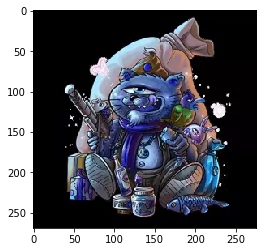

In [21]:
plt.imshow(im[:,:,:3].asnumpy())

In [75]:
import mxnet
mxnet

<module 'mxnet' from '/usr/local/lib/python3.5/dist-packages/mxnet/__init__.py'>